# Executive summary

The report would aim to have reasonable forecasts of Covid-19 daily cases in the next 15 days based on past behviours of the time series. In the analysis below, two approaches, which are Holt Winters smooting and Autoregressive Integrated Moving Average (ARIMA), are proposed and utilised. It turns out that the latter model offers a better insight of data behaviours. Although perfect forecasts cannot be perfectly achieved, it is expected 15 predicted figures offer some valuable information for the Health department to have appropriate strategies dealing with the pandemic.

# Exploratory data analysis

In [1]:
# Import relevant packages
import matplotlib.pyplot as plt
import statsmodels as sm
import statsmodels.api as smt
import numpy as np
import pandas as pd
import seaborn as sns

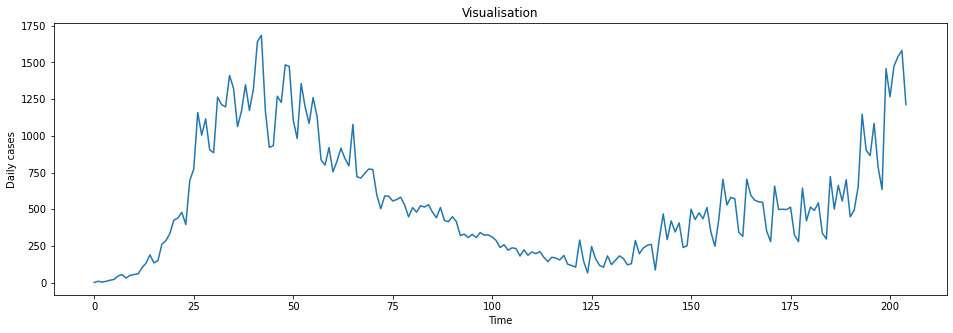

In [2]:
# Read data
data = pd.read_csv('Covid_19_train.csv')
time = data['Time']
data = data['Daily_cases']

# Plot data
plt.figure(figsize=(16,5))
plt.plot(data)
plt.xlabel('Time')
plt.ylabel('Daily cases')
plt.title('Visualisation')
plt.show()

In [3]:
data.describe()

count     205.000000
mean      552.014634
std       403.952658
min         1.000000
25%       239.000000
50%       475.000000
75%       773.000000
max      1685.000000
Name: Daily_cases, dtype: float64

In [4]:
time

0      2020-02-29
1      2020-03-01
2      2020-03-02
3      2020-03-03
4      2020-03-04
          ...    
200    2020-09-16
201    2020-09-17
202    2020-09-18
203    2020-09-19
204    2020-09-20
Name: Time, Length: 205, dtype: object

There are 205 daily observations from the end of February to 20/09/2020. Overall, there is no abnormal value or missing values found in the sample. Therefore, no data cleaning is proposed in this case. Regarding the time series behaviour, form the graph, daily cases do not fluctuate a constant level but change dramatically throughout the period. This observation is further supported by the large standard deviation of 403.95 cases when the range is only between 1 and 1685. Furthermore, from epidemiology perspective, there has been a first wave of Covid-19 around April, and there is a potential second outbreak around September. Hence, it is expected that forecast models may suggest increasing cases in near future.   

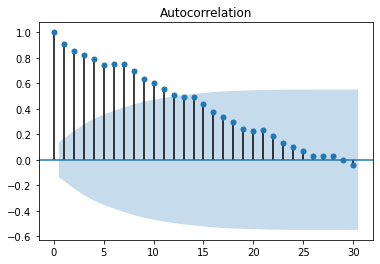

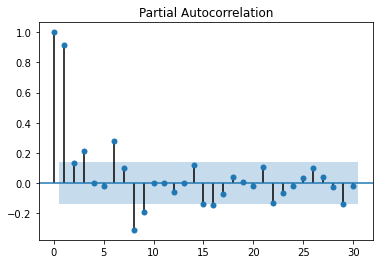

In [5]:
# Plot the ACF for the data
smt.graphics.tsa.plot_acf(data, lags=30, alpha = 0.05)

# Plot the PACF for the data
smt.graphics.tsa.plot_pacf(data, lags=30, alpha=0.05)
plt.show()

In [6]:
from statsmodels.tsa.stattools import adfuller

def test_stationarity(timeseries):

     #Perform Dickey-Fuller test:

    print('Results of Dickey-Fuller Test:')

    dftest = adfuller(timeseries, autolag='AIC')

    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of    Observations Used'])

    for key,value in dftest[4].items():

          dfoutput['Critical Value (%s)'%key] = value

    print(dfoutput)

# now, given a time series ts

test_stationarity(data)

Results of Dickey-Fuller Test:
Test Statistic                     -1.771276
p-value                             0.394813
#Lags Used                         13.000000
Number of    Observations Used    191.000000
Critical Value (1%)                -3.465059
Critical Value (5%)                -2.876794
Critical Value (10%)               -2.574901
dtype: float64


In terms of correlations between daily cases, looking back 30 past values suggest there are some considerable relationships. Specifically, the ACF graph does not die down or cut off quickly. For PACF plot, the behaviour may be more favourable, but significant relationships are still found. Therefore, regarding stationarity, this sample is not preferrable for ARMA model, suggesting some transformations may be necessary. The significant p-value of Dickey-Fuller test further supports this idea. 

# Autoregressive Integrated Moving Average Model (ARIMA)

### Log transformation

From Exploratory data analysis above, the report writer would now perform some adjustments to the sample so that the results obtained from ARIMA could be interpreted with more reliability. Initially, log transformation is made to stabilise the variance of the sample. Evidently, small values have been inflated, and large values have been deflated, resulting in smaller standard deviation. Still, stationarity has not been achieved.

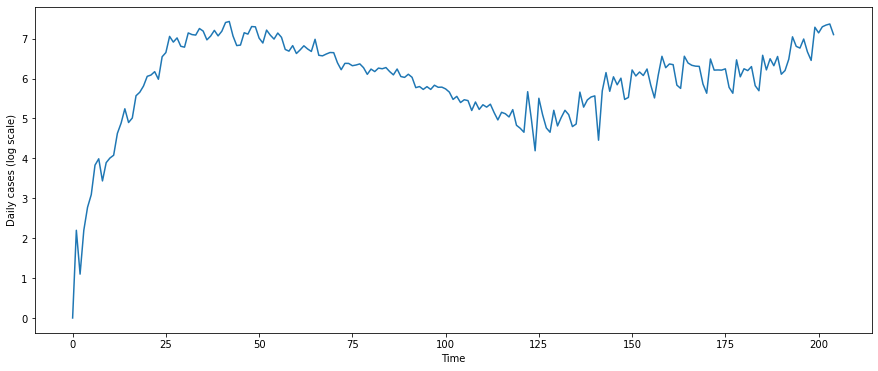

In [7]:
data_log = np.log(data) 
plt.figure(figsize = (15,6))
plt.plot(data.index, data_log)
plt.xlabel('Time')
plt.ylabel('Daily cases (log scale)')
plt.show()

In [8]:
data_log.describe()

count    205.000000
mean       5.937931
std        1.085220
min        0.000000
25%        5.476464
50%        6.163315
75%        6.650279
max        7.429521
Name: Daily_cases, dtype: float64

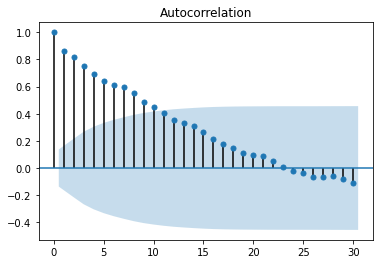

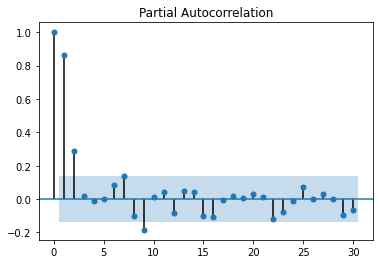

In [9]:
# Plot the ACF for the data
smt.graphics.tsa.plot_acf(data_log, lags=30, alpha = 0.05)

# Plot the PACF for the data
smt.graphics.tsa.plot_pacf(data_log, lags=30, alpha=0.05)
plt.show()

In [10]:
test_stationarity(data_log)

Results of Dickey-Fuller Test:
Test Statistic                     -1.878684
p-value                             0.342154
#Lags Used                         11.000000
Number of    Observations Used    193.000000
Critical Value (1%)                -3.464694
Critical Value (5%)                -2.876635
Critical Value (10%)               -2.574816
dtype: float64


### Seasonal decomposition

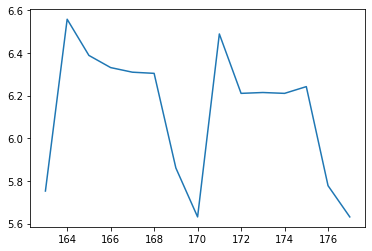

In [11]:
data_log[163:178].plot()

It is observed that there is a potential weekly seasonal pattern, especially at the second half of the sample. Hence, the report would like to separate this behaviour and use ARIMA on the adjusted data. It is hoped that the model could spot other hidden behaviours that cannot be captured by visualisation only. Also, it should be noted that while the seasonal component is left out of model estimation, it would be incorporated eventually for optimal forcecasts. 

In [12]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Perform seasonal decomposition
data_log_dec = seasonal_decompose(data_log, period = 7)

# Extract the trend and seasonal components
data_log_trend = data_log_dec.trend
data_log_seasonal = data_log_dec.seasonal
data_log_resid = data_log_dec.resid

# Construct the seasonally adjusted series
data_log_adjusted = (data_log - data_log_seasonal)

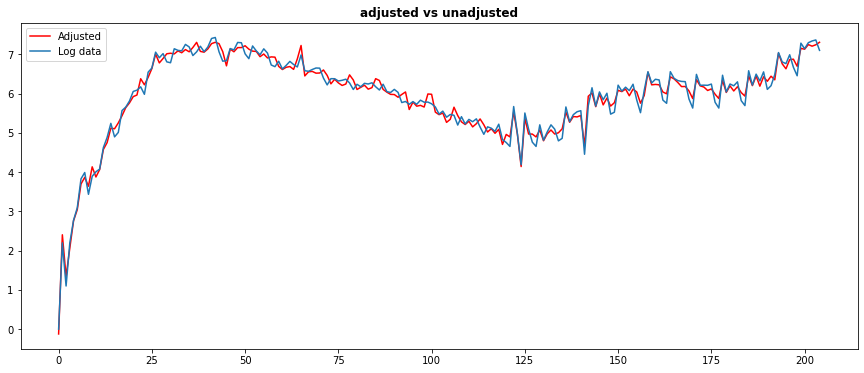

In [13]:
# Plot between adjusted log data and log data
fig, ax = plt.subplots(figsize=(15, 6))

data_log_adjusted.plot(ax=ax, color = 'r', label='Adjusted')
data_log.plot(ax=ax, label='Log data')
ax.set_title('adjusted vs unadjusted', fontsize='large', fontweight='bold');
ax.legend();

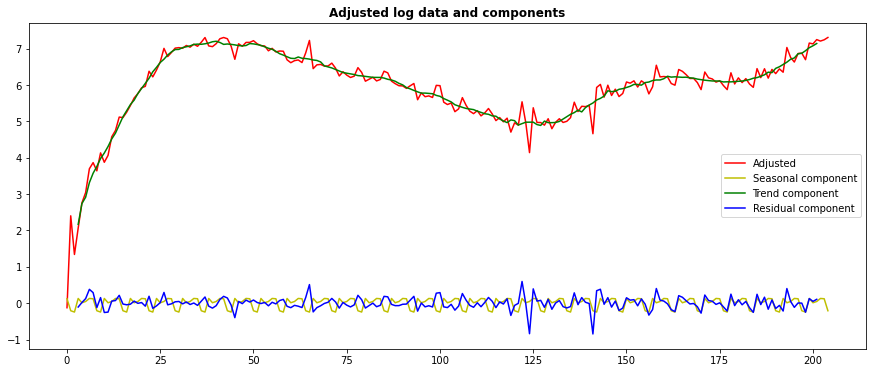

In [14]:
# Plot between adjusted log data and components
fig, ax = plt.subplots(figsize=(15, 6))

data_log_adjusted.plot(ax=ax, color = 'r', label='Adjusted')
data_log_seasonal.plot(ax=ax, color='y', label='Seasonal component')
data_log_trend.plot(ax=ax, color = 'g', label='Trend component')
data_log_resid.plot(ax=ax, color = 'b', label='Residual component')

ax.set_title('Adjusted log data and components', fontsize='large', fontweight='bold');
ax.legend();

### 1st differencing

In [15]:
test_stationarity(data_log_adjusted)

Results of Dickey-Fuller Test:
Test Statistic                     -1.958047
p-value                             0.305265
#Lags Used                         11.000000
Number of    Observations Used    193.000000
Critical Value (1%)                -3.464694
Critical Value (5%)                -2.876635
Critical Value (10%)               -2.574816
dtype: float64


Since the data is still not stationary, Box and Jenkins's suggestion would be utilised. Particularly, instead of performing analysis on log adjusted data, differences between a value and its lagged-one observation would be considered. 

In [16]:
data_log_adjusted_diff = data_log_adjusted - data_log_adjusted.shift()
data_log_adjusted_diff.dropna(inplace=True)
data_log_adjusted_diff

1      2.526883
2     -1.062566
3      0.724528
4      0.693810
5      0.283708
         ...   
200   -0.022757
201    0.118050
202   -0.040204
203    0.034915
204    0.064065
Length: 204, dtype: float64

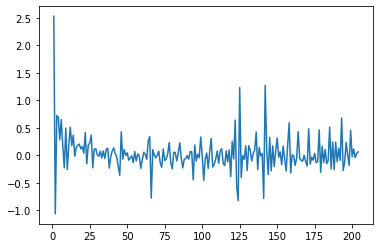

In [17]:
data_log_adjusted_diff.plot()

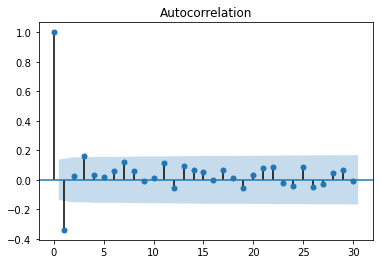

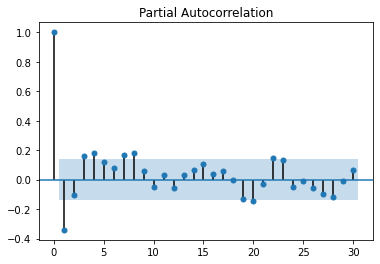

In [18]:
# Plot the ACF for the data
smt.graphics.tsa.plot_acf(data_log_adjusted_diff, lags=30, alpha = 0.05)
# Plot the PACF for the data
smt.graphics.tsa.plot_pacf(data_log_adjusted_diff, lags=30, alpha=0.05)
plt.show()

In [19]:
test_stationarity(data_log_adjusted_diff)

Results of Dickey-Fuller Test:
Test Statistic                     -3.630416
p-value                             0.005205
#Lags Used                         10.000000
Number of    Observations Used    193.000000
Critical Value (1%)                -3.464694
Critical Value (5%)                -2.876635
Critical Value (10%)               -2.574816
dtype: float64


Fortunately, from both the graphs and Dickey-Fuller test, stationarity is broadly achieved. Therefore, this transformed data would now be used as inputs for ARIMA model.

### AIC/BIC selection

In [20]:
import statsmodels.tsa.stattools as st 
import warnings
warnings.filterwarnings("ignore") # turing off Python warning about future release related to the following code

orderlogdec = st.arma_order_select_ic(data_log_adjusted_diff,max_ar=4,max_ma=4,ic=['aic','bic'])
orderlogdec

{'aic':             0           1          2          3          4
 0  133.275677  105.127586  93.930292  94.117705  96.076507
 1  100.126617  100.852400  53.774191  95.683498  93.491924
 2   99.652616   87.619809  55.699824  54.175281  55.710007
 3   96.243256   69.216639  56.946250  55.577977  59.277101
 4   91.981294   69.012712  48.641080  55.724806  60.692935,
 'bic':             0           1           2           3           4
 0  139.911917  115.081946  107.202772  110.708305  115.985227
 1  110.080977  114.124880   70.364791  115.592218  116.718764
 2  112.925096  104.210408   75.608544   77.402121   82.254967
 3  112.833856   89.125359   80.173090   82.122937   89.140181
 4  111.890014   92.239552   75.186040   85.587886   93.874135,
 'aic_min_order': (4, 2),
 'bic_min_order': (1, 2)}

Although (4,2) and (1,2) are suggested by AIC and BIC respectively, there are other pairs of (p,q) that also result in values not significantly higher than the suggestions. Therefore, for a more well-rounded perspective, all pairs (p,q) of [(1,1), (1,2), (1,3), (1,4), (2,1), (2,2), (2,3), (2,4), (3,1), (3,2), (4,1)] would be run to ensure enough analysis for final selection. Circumstances when p=0 or q=0 are left out because the levels of AIC and BIC are significantly higher than other scenarios. Also, for the remaining pairs that have not been considered, several trials have been done, but problems of MA/AR invertibility persist, so those circumstances would be removed as well (see supplementary file for more details).

### Train/Validation fitting illustration

The report would now perform one illustration of splitting data into training and validation set and to get an idea of the model performance in future forecast. Let the validation size = 7 and (1,1,2) as the (p,d,q) set, the validation RMSE are calculated through several steps as followed:

In [21]:
from statsmodels.tsa.arima_model import ARIMA

# Split the data (205 observations => 198 for training; 7 for validation)
data_log_train7 = data_log[:198]
data_log_valid7 = data_log[198:]

# Seasonal decomposition on training data
data_log_train7_dec = seasonal_decompose(data_log_train7, period = 7)
data_log_train7_adjusted = (data_log_train7 - data_log_train7_dec.seasonal)

# Fit the adjusted training data with ARIMA(1,1,2)
p,q = 1,2
model_log_adjusted_7 = ARIMA(data_log_train7_adjusted, order=(p, 1, q))
results_log_adjusted_7_ARIMA = model_log_adjusted_7.fit(disp=-1)

# Forecast next 7 days based on ARIMA(1,1,2) fitted on training data
valid_log_dec_without_seasonal = results_log_adjusted_7_ARIMA.forecast(steps=7)
yhat_log_dec_without_seasonal = valid_log_dec_without_seasonal[0]

# Add seasonal to yhat (this is on log scale)
yhat_log_dec_with_seasonal = yhat_log_dec_without_seasonal + data_log_train7_dec.seasonal[2:9]

# Back to normal scale
yhat = np.exp(yhat_log_dec_with_seasonal)

#Calculate validation RMSE
actual = np.array(np.exp(data_log_valid7))
validRMSE7 = np.sqrt(np.mean((yhat-actual)**2))
validRMSE7


160.58925122032375

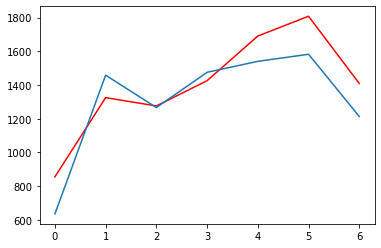

In [22]:
# Visualisation
plt.plot(np.array(yhat), color='r')
plt.plot(actual)

### Train/Validation fitting with different pairs and splits

The 'Train/Validation fitting illustration' right above shows all necessary steps to calculate validation RMSE given validation size and (p,d,q) set. However, the report wants to further check the consistency of performance with different validation sizes to select a robust (p,d,q) set. Therefore, a loop code is created to split data into different validation sizes from 1 to 28 each iteration and compute 28 different validation RMSEs accordingly.

Only a maximum validation size of 28 is set because it is believed that further split would cause information loss, which means the model does not have enough data to study and capture patterns. This is especially important as there is an increasing trend in data at the end of the sample size. Also, since we only have to forecast next 15 data points, there is no point requiring the model looking too far. 

The loop can be generally explained as follow:

1/ Of 11 pairs (p,q) selected above, each would be used to fit ARIMA(p,1,q) on the training set.

2/ The training set would have size from 204 (=205-1) to 177 (205-28) in 28 iterations. Correspondingly, The validation set would have size from 1 to 28.

3/ After each iteration, a validation RMSE would be obtained. For example, the first validation RMSE would be on (training 204/validation 1) and so on.

4/ The loop ends when 308 validation RMSEs have been obtained (28 for each (p,q) pair; total 11 pairs)

In [23]:
# The loop

for p,q in [(1,1), (1,2), (1,3), (1,4), (2,1), (2,2), (2,3), (2,4), (3,1), (3,2), (4,1)]:
        
        print('The set (p,d,q) is (', p,1,q, ')')
        validRMSElist=[]
        for j in range (1,29,1):
        
            # Split data
            data_log_train = data_log[:205-j]
            data_log_valid = data_log[205-j:]
            # Seasonal decomposition
            data_log_train_dec = seasonal_decompose(data_log_train, period = 7)
            data_log_train_adjusted = (data_log_train - data_log_train_dec.seasonal)
            # Fit ARIMA on training data
            model_log_adjusted = ARIMA(data_log_train_adjusted, order=(p, 1, q))
            results_log_adjusted_ARIMA = model_log_adjusted.fit(disp=-1)
            # Forecast next j steps
            valid_log_dec_without_seasonal = results_log_adjusted_ARIMA.forecast(steps=j)
            yhat_log_dec_without_seasonal = valid_log_dec_without_seasonal[0]
            # Add seasonal to yhat (this is on log scale)
            remainder = data_log_train.size%7
            yhat_log_dec_with_seasonal = yhat_log_dec_without_seasonal + data_log_train_dec.seasonal[remainder:remainder+j]
            # Back to normal scale
            yhat = np.exp(yhat_log_dec_with_seasonal)
            #Calculate validation RMSE
            actual = np.array(np.exp(data_log_valid))
            validRMSE = np.sqrt(np.mean((yhat-actual)**2))
            validRMSElist.append(validRMSE)
        print('The validation RMSE for each iteration from validation size 1 to 28 in this set is')
        print(validRMSElist)
        print('Mean of all validation RMSE with this set', np.mean(validRMSElist))
        print('Standard deviation of all validation RMSE with this set', np.std(validRMSElist))
        print('------------------------------------------------------------')
        

The set (p,d,q) is ( 1 1 1 )
The validation RMSE for each iteration from validation size 1 to 28 in this set is
[34.80021698511109, 34.81424036611636, 52.825297383636126, 69.09367711341736, 176.7326459334417, 412.2870528016257, 249.41748666659984, 275.69055808071, 325.75178835878825, 179.85392608451642, 173.80933665406576, 476.6189928477142, 424.8657751497251, 421.95921755642934, 381.1494484360495, 404.9056691179241, 302.8099631930481, 339.6241317356322, 318.2943476664156, 477.6514685064776, 387.88234229293954, 319.95653210186094, 317.7134931309273, 262.782406249358, 258.9507896263278, 217.94216834139706, 346.19186209967035, 255.4900973365072]
Mean of all validation RMSE with this set 282.1380332791583
Standard deviation of all validation RMSE with this set 125.80964920494024
------------------------------------------------------------
The set (p,d,q) is ( 1 1 2 )
The validation RMSE for each iteration from validation size 1 to 28 in this set is
[94.1182552763189, 169.87664459448274, 1

The validation RMSE for each iteration from validation size 1 to 28 in this set is
[78.34156748018063, 161.83887165712602, 192.21238549002953, 115.98706021423413, 131.06975279478004, 317.49693551493783, 157.10513648233336, 127.9559982989431, 108.12600506568468, 236.67498151864666, 147.80697248951947, 484.85338111657563, 413.73080354253193, 434.46551907029374, 349.2988309056186, 387.0306799985284, 195.22729810616022, 381.9725400457161, 418.8435741477238, 650.7317808335708, 541.6766735230854, 438.96764223372537, 454.245717970155, 333.5574908626343, 436.60728269323243, 418.4217274601663, 632.9289212050643, 521.8953039735394]
Mean of all validation RMSE with this set 331.0382440962406
Standard deviation of all validation RMSE with this set 164.2082715628998
------------------------------------------------------------


Overall, all analysed sets considerable forecating performance, thus suggesting validity of AIC and BIC. However, in terms of predictability performance, two sets (3,1,2) and (1,1,1) are the significantly stable. Evidently, in both cases, validation RMSE gradually becomes smaller when there are more training data despite minor frequent surges in some iterations (e.g., from validation size 11 to 10).This is further supported through the small computed means and standard deviations of RMSE lists obtained in these two models.

Further analysis reveals that ARIMA(3,1,2) actually performs better in h-step forecast when h is high (i.e., >10). Nevertheless, it is inferior to ARIMA(1,1,1) with near-future forecasts. With these findings, the report now proposes an combination of forecasts between these two models. The objective is to overcome the poor performance of ARIMA(3,1,2) in close forecasts and keep the advantage of its further predictability. In other words, the report seeks to improve stability of prediction over time so that the outputs can be interpreted with more reliability

Because the aim of the study is to have 15-day forecasts, it is reasonably chosen that 85% weight would be applied to ARIMA(3,1,2) forecasts and 15% to ARIMA(1,1,1) to arrive at the final result. The same loop would now be run on this combination to check the validity of the suggestion.



Break down of loop code for ARIMA combination below:

1/ Run 28 iterations similar to the previous loop on ARIMA(3,1,2) and ARIMA(1,1,1)

2/ Obtain two lists of forecasts figures from ARIMA(3,1,2) and ARIMA(1,1,1) in each iteration. The number of forecasts would be equal to the number of observations in the validation set for EACH ARIMA.

3/ Add seasonal component to two lists of forecasts figures

4/ Calculate final forecasts using weighted average (this is on log scale): 0.85\*ARIMA(3,1,2)_Forecast_list + 0.15\*ARIMA(1,1,1)_Forecast_list

5/ Back to the normal scale for the final forecasts

6/ Calculate RMSE and repeat until 28 validation RMSEs are found

In [24]:
        validRMSEcombinedlist=[]
        for j in range (1,29,1):
            
            # Split data
            data_log_train = data_log[:205-j]
            data_log_valid = data_log[205-j:]
            # Seasonal decomposition
            data_log_train_dec = seasonal_decompose(data_log_train, period = 7)
            data_log_train_adjusted = (data_log_train - data_log_train_dec.seasonal)
            
            # Fit ARIMA on training data
            model1 = ARIMA(data_log_train_adjusted, order=(3, 1, 2))
            result1_ARIMA = model1.fit(disp=-1)
            model2 = ARIMA(data_log_train_adjusted, order=(1, 1, 1))
            result2_ARIMA = model2.fit(disp=-1)
            
            # Forecast next j steps
            valid1_without_seasonal = result1_ARIMA.forecast(steps=j)
            valid2_without_seasonal = result2_ARIMA.forecast(steps=j)
            
            yhat1_without_seasonal = valid1_without_seasonal[0]
            yhat2_without_seasonal = valid2_without_seasonal[0]
            
            # Add seasonal to yhat (this is on log scale)
            remainder = data_log_train.size%7
            yhat1_with_seasonal = yhat1_without_seasonal + data_log_train_dec.seasonal[remainder:remainder+j]
            yhat2_with_seasonal = yhat2_without_seasonal + data_log_train_dec.seasonal[remainder:remainder+j]
            
            # Back to normal scale
            yhat = np.exp(0.85*yhat1_with_seasonal+0.15* yhat2_with_seasonal)
            #Calculate validation RMSE
            actual = np.array(np.exp(data_log_valid))
            validRMSE = np.sqrt(np.mean((yhat-actual)**2))
            validRMSEcombinedlist.append(validRMSE)
        print('The validation RMSE for each iteration from validation size 1 to 28 in combined set is')
        print(validRMSEcombinedlist)
        print('Mean of all validation RMSE with this combination', np.mean(validRMSEcombinedlist))
        print('Standard deviation of all validation RMSE with this combination', np.std(validRMSEcombinedlist))
        print('------------------------------------------------------------')

The validation RMSE for each iteration from validation size 1 to 28 in combined set is
[75.34003764941303, 162.92327188777344, 149.74949291945282, 102.13245975889224, 79.92215366698498, 181.42005747201875, 139.2576980176912, 132.3433615268329, 115.83396159665747, 245.81141875130183, 167.7697936694347, 320.4975913735114, 298.21068772764494, 293.5907370932782, 245.37521989176687, 305.40900095497415, 199.5721986890769, 348.2359823759639, 310.5321175365003, 488.6717135467622, 355.95821079343017, 306.5241263379938, 321.0095245932647, 303.38638618328565, 279.17109047728275, 380.09925081292687, 563.426052202082, 457.19986899067504]
Mean of all validation RMSE with this combination 261.76333808917406
Standard deviation of all validation RMSE with this combination 122.03803544773204
------------------------------------------------------------


From the output, there are considerable findings for this combination:

-For only near short-term forecasts are needed (i.e., within 10 days), the combination ARIMA considerably performs better than ARIMA(3,1,2). This may suggest that with more data in the training set, the predictability power of the combination ARIMA is very promising.

-For long-term forecasts, however, ARIMA(3,1,2) seems to capture the main pattern of data better than the combination set. Intuitively, this may be partly explained by the fact that when validation size larger or equal to 10 the increasing trend may not be captured by ARIMA(1,1,1). Still, the combination output is not significantly worse than ARIMA(3,1,2) and still outperforms other ARIMA models considered.

-The mean of validation RMSE of the combination is smaller than that of ARIMA(3,1,2), and the standard deviation is only slightly higher. This indicates the stability of prediction is still preserved.

With these outcomes, the report would decide to make the next 15 forecasts based on this combination. It is hoped that when the whole available data set is used for training, the patterns would be captured well in both ARIMA models, thus resulting in overall final reliable forecasts.

Next, the whole dataset is fitted with ARIMA(3,1,2) and ARIMA(1,1,1) to make predictions.

### Fit the whole data with ARIMA(3,1,2) and ARIMA(1,1,1) to arrive at the combined forecasts

In [25]:
#Fit ARIMA(3,1,2)
model1_final = ARIMA(data_log_adjusted, order=(3, 1, 2))
result1_final_ARIMA = model1_final.fit(disp=-1)
print(result1_final_ARIMA.summary())

                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                  204
Model:                 ARIMA(3, 1, 2)   Log Likelihood                 -21.473
Method:                       css-mle   S.D. of innovations              0.266
Date:                Sun, 14 Nov 2021   AIC                             56.946
Time:                        23:30:11   BIC                             80.173
Sample:                             1   HQIC                            66.342
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1513      0.143      1.057      0.290      -0.129       0.432
ar.L1.D.y      1.0196      0.133      7.665      0.000       0.759       1.280
ar.L2.D.y      0.0842      0.121      0.695      0.4

In [26]:
#Fit ARIMA(1,1,1)
model2_final = ARIMA(data_log_adjusted, order=(1, 1, 1))
result2_final_ARIMA = model2_final.fit(disp=-1)
print(result2_final_ARIMA.summary())

                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                  204
Model:                 ARIMA(1, 1, 1)   Log Likelihood                 -46.426
Method:                       css-mle   S.D. of innovations              0.304
Date:                Sun, 14 Nov 2021   AIC                            100.852
Time:                        23:30:11   BIC                            114.125
Sample:                             1   HQIC                           106.221
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0322      0.014      2.367      0.018       0.006       0.059
ar.L1.D.y     -0.3548      0.129     -2.749      0.006      -0.608      -0.102
ma.L1.D.y     -0.1362      0.115     -1.180      0.2

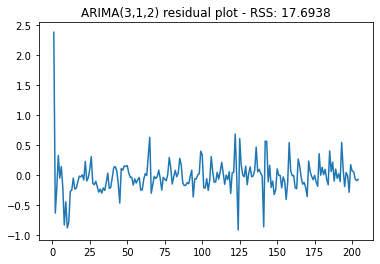

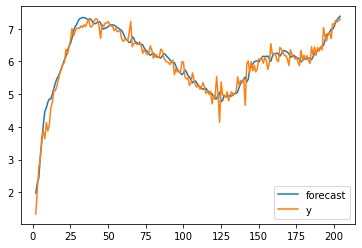

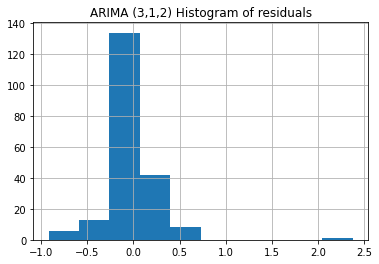

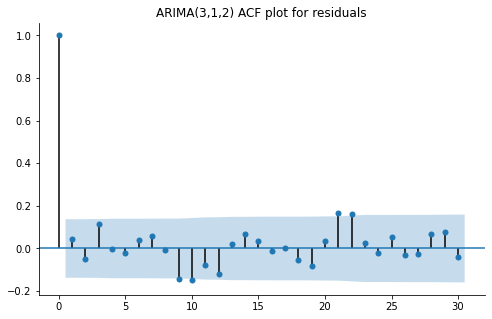

In [27]:
residual1_final = pd.DataFrame(result1_final_ARIMA.resid)

# Plot the residuals and compute the RSS 
plt.figure()
plt.plot(residual1_final)
plt.title('ARIMA(3,1,2) residual plot - RSS: %.4f'% sum((result1_final_ARIMA.resid.values)**2))
plt.show()

# Get Fitted Series
fitted1_AIC = result1_final_ARIMA.predict(typ = 'levels', dynamic = False)

# Actual vs Fitted
result1_final_ARIMA.plot_predict(dynamic=False)
plt.show()

#Histogram of residuals
residual1_final.hist()
plt.title('ARIMA (3,1,2) Histogram of residuals')

#ACF plot for residuals
fig, ax = plt.subplots(figsize=(8,5))
smt.graphics.tsa.plot_acf(residual1_final, lags=30, ax=ax)
sns.despine()
plt.title('ARIMA(3,1,2) ACF plot for residuals')
plt.show()

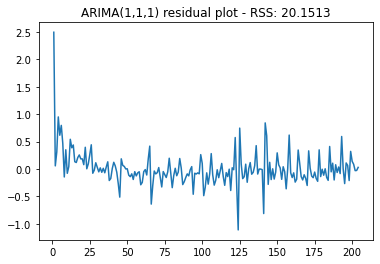

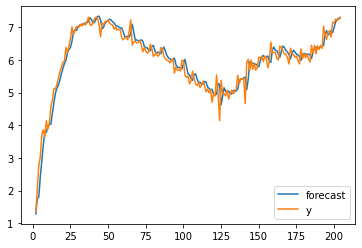

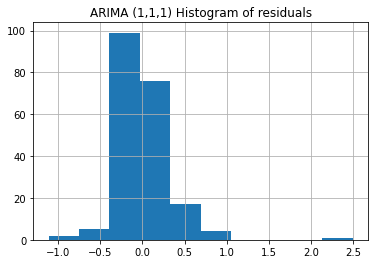

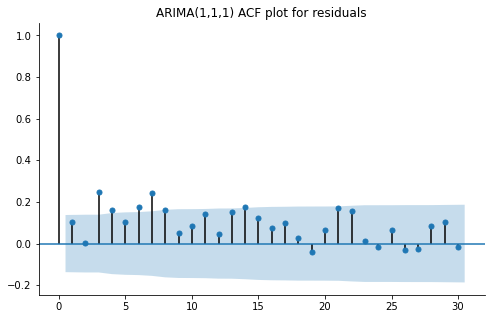

In [28]:
residual2_final = pd.DataFrame(result2_final_ARIMA.resid)

# Plot the residuals and compute the RSS 
plt.figure()
plt.plot(residual2_final)
plt.title('ARIMA(1,1,1) residual plot - RSS: %.4f'% sum((result2_final_ARIMA.resid.values)**2))
plt.show()

# Get Fitted Series
fitted2_AIC = result2_final_ARIMA.predict(typ = 'levels', dynamic = False)

# Actual vs Fitted
result2_final_ARIMA.plot_predict(dynamic=False)
plt.show()

#Histogram of residuals
residual2_final.hist()
plt.title('ARIMA (1,1,1) Histogram of residuals')

#ACF plot for residuals
fig, ax = plt.subplots(figsize=(8,5))
smt.graphics.tsa.plot_acf(residual2_final, lags=30, ax=ax)
sns.despine()
plt.title('ARIMA(1,1,1) ACF plot for residuals')
plt.show()

Analysis of residuals shows considerable forecasting abilities of the model. Specifically, residuals fluctuate mostly around zero, and there seems to be no significant patterns that have not been captured in the ACF plot. This creates some credibility and confidence in future forecasts.

In [29]:
# Forecast next 15 steps
forecast1_without_seasonal = result1_final_ARIMA.forecast(steps=15)
yhat1_without_seasonal = forecast1_without_seasonal[0]

forecast2_without_seasonal = result2_final_ARIMA.forecast(steps=15)
yhat2_without_seasonal = forecast2_without_seasonal[0]

# Add seasonal to yhat (this is on log scale)
remainder = data_log.size%7
yhat1_with_seasonal = yhat1_without_seasonal + data_log_dec.seasonal[remainder:remainder+15]
yhat2_with_seasonal = yhat2_without_seasonal + data_log_dec.seasonal[remainder:remainder+15]

# Back to normal scale
yhat_final = np.exp(0.85*yhat1_with_seasonal+0.15*yhat2_with_seasonal)

print(yhat_final)

2     1303.568530
3     2017.584221
4     1915.317630
5     2109.939331
6     2441.805647
7     2579.176555
8     1975.999110
9     2031.444944
10    3148.924741
11    2984.240947
12    3298.029788
13    3828.172107
14    4057.671527
15    3119.500442
16    3218.249418
Name: seasonal, dtype: float64


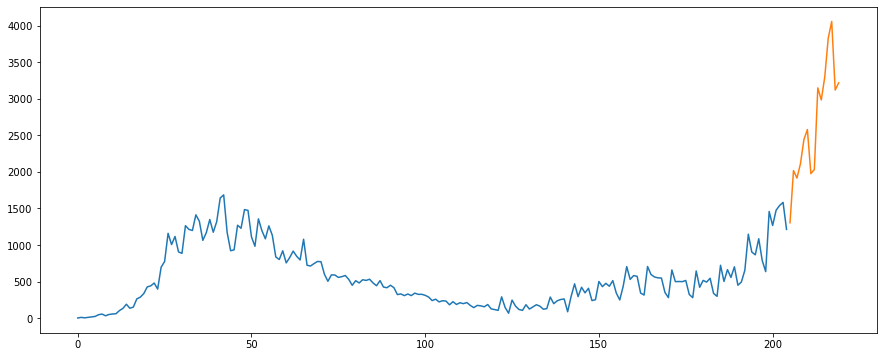

In [30]:
fig, ax = plt.subplots(figsize=(15, 6))
data.plot()
plt.plot(range(205,220),yhat_final)

# Holt-Winters smoothing

After ARIMA, Holt-Winters smoothing is the second model considered. This is because seasonality, which has been observed, can be captured in this method comparing to simple exponential smoothing or Trend-corrected smoothing.

In [31]:
import forecast
import statlearning

In [32]:
ahw=forecast.holtwinters(data, additive=True, damped=False, m=7)
ahw.fit()
ahw.summary()

 Additive Holt-winters exponential smoothing

 Smoothing parameters:
 alpha (level)    0.234 (0.041)
 beta  (trend)    0.255 (0.058)
 delta (seasonal) 0.413 (0.070)
 
 In-sample fit:
 MSE               16048.727
 RMSE              126.684
 Log-likelihood   -1283.429
 AIC               2574.859
 BIC               2588.151


In [33]:
ahw_damped=forecast.holtwinters(data, additive=True, damped=True, m=7)
ahw_damped.fit()
ahw_damped.summary()

 Additive Holt-winters exponential smoothing (damped trend)

 Smoothing parameters:
 alpha (level)    0.219 (0.033)
 beta  (trend)    0.280 (0.181)
 delta (seasonal) 0.404 (0.076)
 phi (damping)    0.959 (0.055)
 
 In-sample fit:
 MSE               15944.035
 RMSE              126.270
 Log-likelihood   -1282.759
 AIC               2575.517
 BIC               2592.132


In [34]:
mhw=forecast.holtwinters(data, additive=False, damped=False, m=7)
mhw.fit()
mhw.summary()

 Multiplicative Holt-winters exponential smoothing

 Smoothing parameters:
 alpha (level)    0.262 (0.047)
 beta  (trend)    0.000 (0.070)
 delta (seasonal) 0.872 (0.065)
 
 In-sample fit:
 MSE               20269.443
 RMSE              142.371
 Log-likelihood   -1307.362
 AIC               2622.723
 BIC               2636.015


In [35]:
mhw_damped=forecast.holtwinters(data, additive=False, damped=True, m=7)
mhw_damped.fit()
mhw_damped.summary()

 Multiplicative Holt-winters exponential smoothing (damped trend)

 Smoothing parameters:
 alpha (level)    0.119 (0.194)
 beta  (trend)    1.000 (1.679)
 delta (seasonal) 0.658 (0.266)
 phi (damping)    0.577 (0.492)
 
 In-sample fit:
 MSE               19208.814
 RMSE              138.596
 Log-likelihood   -1301.853
 AIC               2613.705
 BIC               2630.320


In [36]:
ahw_log=forecast.holtwinters(data_log, additive=True, damped=False, m=7)
ahw_log.fit()
ahw_log.summary()

 Additive Holt-winters exponential smoothing

 Smoothing parameters:
 alpha (level)    0.176 (0.046)
 beta  (trend)    0.245 (0.110)
 delta (seasonal) 0.768 (0.102)
 
 In-sample fit:
 MSE               0.161
 RMSE              0.401
 Log-likelihood   -103.800
 AIC               215.600
 BIC               228.892


In [37]:
ahw_log_damped=forecast.holtwinters(data_log, additive=True, damped=True, m=7)
ahw_log_damped.fit()
ahw_log_damped.summary()

 Additive Holt-winters exponential smoothing (damped trend)

 Smoothing parameters:
 alpha (level)    0.152 (0.039)
 beta  (trend)    0.289 (0.156)
 delta (seasonal) 0.752 (0.104)
 phi (damping)    0.949 (0.033)
 
 In-sample fit:
 MSE               0.158
 RMSE              0.398
 Log-likelihood   -101.787
 AIC               213.574
 BIC               230.189


It should be noted that after log transformation has been applied to the data, multiplicative models are not mathematically feasible, so they are not presented above. Based on AIC/BIC, intial observations show that additive Holt-winters model both with damped or not perform similarly in either original or log-transformed data. Therefore, 'ahw', 'ahw_damped', 'ahw_log', and 'ahw_log_damped' would all be analysed. Furthermore, the combined ARIMA above would also be checked against this branch of time series forecasting.

In this case, real-time forecasting, a common technique to compare between different models would be utilised. Again, only up to validation size of 28 is considered as explained above. Here is the brief procedure description:

1/ Run 28 iterations with similar split to previous loops

2/ In each iteration, 1-step forecast is obtained used to calculate RMSE (i.e., only a single value forecasted in an iteration)

3/ Repeat until all possible 1-step forecasts are found (i.e., validation size = 0)

In [38]:
# Real time forecasting 

pred1 = [] # additive holt winters
pred2 = [] # additive damped holt winters
pred3 = [] # additive log holt winters
pred4 = [] # additive log damped holt winters
pred5 = [] # ARIMA(3,1,2)
actual= []

for i in range(28):
    
    actual.append(data[177+i]) # actual value
    
    model = forecast.holtwinters(data[:177+i], additive=True, damped=False, m=7)
    model.fit()
    pred1.append(model.forecast(1)[0]) # additive holt winters forecast
    
    model = forecast.holtwinters(data[:177+i], additive=True, damped=True, m=7)
    model.fit()
    pred2.append(model.forecast(1)[0]) # additive damped holt winters forecast
    
    model = forecast.holtwinters(data_log[:177+i], additive=True, damped=False, m=7)
    model.fit()
    pred3.append(np.exp(model.forecast(1)[0])) # additive log holt winters forecast
    
    model = forecast.holtwinters(data_log[:177+i], additive=True, damped=True, m=7)
    model.fit()
    pred4.append(np.exp(model.forecast(1)[0])) # additive log damped holt winters forecast
    
    data_log_train = data_log[:177+i]
    data_log_train_dec = seasonal_decompose(data_log_train, period = 7)
    data_log_train_adjusted = (data_log_train - data_log_train_dec.seasonal)
    # Fit ARIMA on training data
    model1 = ARIMA(data_log_train_adjusted, order=(3, 1, 2))
    result1_ARIMA = model1.fit(disp=-1)
    
    model2 = ARIMA(data_log_train_adjusted, order=(1, 1, 1))
    result2_ARIMA = model2.fit(disp=-1)
    
    # Forecast next 1 step
    valid1_without_seasonal = result1_ARIMA.forecast(steps=1)
    yhat1_without_seasonal = valid1_without_seasonal[0]
    valid2_without_seasonal = result2_ARIMA.forecast(steps=1)
    yhat2_without_seasonal = valid2_without_seasonal[0]
    
    # Add seasonal to yhat (this is on log scale)
    remainder = len(data_log_train)%7
    yhat1_with_seasonal = yhat1_without_seasonal + data_log_train_dec.seasonal[remainder:remainder+1]
    yhat2_with_seasonal = yhat2_without_seasonal + data_log_train_dec.seasonal[remainder:remainder+1]
    yhatcombined = 0.85*yhat1_with_seasonal+0.15*yhat2_with_seasonal
    # Back to normal scale
    pred5.append(list(np.exp(yhatcombined))[0])
    



In [39]:
columns=['Additive', 'Additive damped', 'Additive log', 'Additive log damped', 'ARIMA', 'Actual']
results = np.vstack([pred1,pred2,pred3,pred4,pred5,actual]).T
results = pd.DataFrame(results, columns=columns)

from statlearning import rmse_jack

table = pd.DataFrame(0.0, index=results.columns[:-1], columns=['RMSE','SE'])
for i in range(5):
    table.iloc[i,0], table.iloc[i,1] = rmse_jack(results.iloc[:,i], results.iloc[:,-1])
table.round(2)

,RMSE,SE
Additive,174.08,29.38
Additive damped,197.00,31.58
Additive log,169.43,34.10
Additive log damped,192.25,32.98
ARIMA,149.91,33.55


From real-time forecasting above, the ARIMA model found previously still outperforms all four Holt-Winters models on the basis of RMSE. Therefore, ARIMA is still chosen as the final optimal model in this situtation.

# TEST ERROR CALCULATION

In [40]:
# Forecasted figures from ARIMA proposed model
yhat_final

2     1303.568530
3     2017.584221
4     1915.317630
5     2109.939331
6     2441.805647
7     2579.176555
8     1975.999110
9     2031.444944
10    3148.924741
11    2984.240947
12    3298.029788
13    3828.172107
14    4057.671527
15    3119.500442
16    3218.249418
Name: seasonal, dtype: float64

In [41]:
import pandas as pd

covid_19_test = pd.read_csv('Covid_19_test.csv')
# YOUR CODE HERE: code that produces the test error test_error
test_error = np.mean((np.array(yhat_final)-np.array(covid_19_test['Daily_cases']))**2)

print(test_error)

7690834.645294124
